**Installation**

In [0]:
!pip install librosa numpy sklearn pyaudio

In [0]:
import os
import glob

In [0]:
root='/content/drive/My Drive/speech-emotion-recognition'

In [0]:
os.chdir(root)

In [5]:
import librosa     
import os, glob, pickle
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Functions**

In [0]:
def noise(data, noise_factor):
    noise = np.random.randn(len(data))   #0-1 numpy array
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def shift(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif self.shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

In [0]:
def extract_feature(data, sr, mfcc, chroma, mel):
    if chroma:                          
        stft=np.abs(librosa.stft(data))  

    result=np.array([])
    if mfcc:                          
        mfccs=np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:                          
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:                             
        mel=np.mean(librosa.feature.melspectrogram(data, sr=sr).T,axis=0)
        result=np.hstack((result, mel))
    return result 

emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

def load_and_augment(test_size=0.2,random_state=0):
  x,y=[],[]
  for file in glob.glob(root+"/*/*"):  
    data, sr = librosa.load(file)

    feature=extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)

    file_name=os.path.basename(file)
    emotion=emotions[file_name.split("-")[2]]  
    y.append(emotion)

    noise_data=noise(data,0.001)
    noise_feature=extract_feature(noise_data, sr, mfcc=True, chroma=True, mel=True)
    x.append(noise_feature)
    y.append(emotion)

    shift_data=shift(data,sr,0.25,'right')
    shift_feature=extract_feature(shift_data, sr, mfcc=True, chroma=True, mel=True)
    x.append(shift_feature)
    y.append(emotion)
    
  return train_test_split(np.array(x), y, test_size=test_size, random_state=random_state)

**Load and preprocess data**

In [0]:
x_train,x_test,y_train,y_test=load_and_augment(test_size=0.2,random_state=9)

In [0]:
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)
y_train=y_train.reshape(len(y_train),1)
y_test=y_test.reshape(len(y_test),1)
onehotencoder=OneHotEncoder()
y_train=onehotencoder.fit_transform(y_train).toarray()  
y_test=onehotencoder.fit_transform(y_test).toarray()

**Build model**

In [0]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import optimizers
from keras import regularizers
import matplotlib.pyplot as plot 

In [0]:
mlp_model=Sequential()

mlp_model.add(Dense(units=128,activation='relu',input_shape=(180,),
                    kernel_regularizer=regularizers.l2(0.001)
                    ))

mlp_model.add(Dense(units=128,activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)
                    ))

mlp_model.add(Dense(units=128,activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)
                    ))

mlp_model.add(Dropout(0.5))

mlp_model.add(Dense(units=128,activation='relu',
                    # kernel_regularizer=regularizers.l2(0.001)
                    ))

mlp_model.add(Dense(units=128,activation='relu',
                    # kernel_regularizer=regularizers.l2(0.001)
                    ))

mlp_model.add(Dropout(0.5))

mlp_model.add(Dense(units=8,activation="softmax"))
mlp_model.compile(optimizer='adam',
                  # optimizer=optimizers.Adam(lr=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

In [0]:
parameter=mlp_model.fit(x_train,y_train,
                    validation_data=(x_test,y_test),
                    epochs=400,
                    batch_size=30)

Train on 3456 samples, validate on 864 samples
Epoch 1/400
3456/3456 [==============================] - 3s 765us/step - loss: 4.3664 - accuracy: 0.1444 - val_loss: 2.2308 - val_accuracy: 0.1620
Epoch 2/400
3456/3456 [==============================] - 1s 233us/step - loss: 2.2044 - accuracy: 0.1672 - val_loss: 2.1263 - val_accuracy: 0.2002
Epoch 3/400
3456/3456 [==============================] - 1s 233us/step - loss: 2.1547 - accuracy: 0.1861 - val_loss: 2.1160 - val_accuracy: 0.1852
Epoch 4/400
3456/3456 [==============================] - 1s 227us/step - loss: 2.1209 - accuracy: 0.1898 - val_loss: 2.1309 - val_accuracy: 0.1667
Epoch 5/400
3456/3456 [==============================] - 1s 230us/step - loss: 2.1077 - accuracy: 0.1869 - val_loss: 2.1045 - val_accuracy: 0.1713
Epoch 6/400
3456/3456 [==============================] - 1s 233us/step - loss: 2.0908 - accuracy: 0.1962 - val_loss: 2.0253 - val_accuracy: 0.2060
Epoch 7/400
3456/3456 [==============================] - 1s 237us/step 

In [0]:
mlp_model.summary()

In [0]:
mlp_model.evaluate(x_train,y_train)
mlp_model.evaluate(x_test,y_test)

In [0]:
parameter.history.keys()

In [0]:
plot.plot(parameter.history['val_loss'],label='val_loss')
plot.plot(parameter.history['loss'],label='loss')
plot.legend()

In [0]:
plot.plot(parameter.history['val_accuracy'],label='val_acc')
plot.plot(parameter.history['accuracy'],label='acc')
plot.legend()

In [0]:
y_pred = mlp_model.predict_classes(x_test)  

In [0]:
y_final = np.argmax(y_test,axis=1) 

In [0]:
confusion_matrix(y_true = y_final ,y_pred = y_pred)

In [0]:
df_sn = pd.DataFrame(confusion_matrix(y_true = y_final ,y_pred = y_pred))

In [0]:
emotion_label = list(emotions.values())

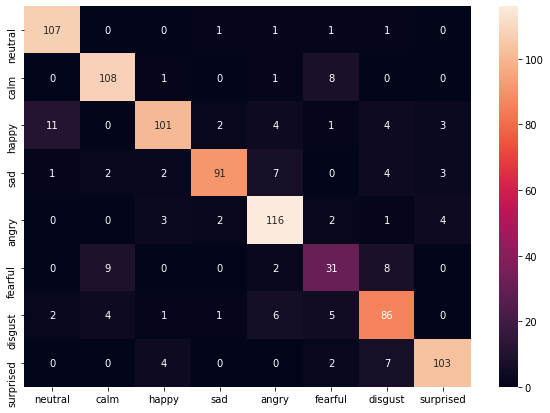

In [0]:
plt.figure(figsize = (10,7))
sn.heatmap(df_sn, annot=True,fmt="d", xticklabels=emotion_label, yticklabels=emotion_label)

In [0]:
f1_score(y_final,y_pred,average='weighted')

0.8597502927058267